# In-Database Image Classification using Xilinx FPGA


We will show how deepgreen can use Xilinx FPGA to perform in-data AI inference.

In [10]:
# Step 1: First import modules we use in this demo
import os,sys,cv2
from __future__ import print_function

from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
# Connect to deepgreen.   Print database version.
import dg.conn
from dg.admin import activity
con = dg.conn.Conn(user="ftian", database="xilinx", port=5432)
print (con.ver)

5


In [12]:
# We have setup xdrive to ls image files.  Deepgreen can use xdrive to 
# access files stored in filesystem (or HDFS/S3 etc).   We have set up
# the table imagefiles to acess lots of images.   
# 
xt = dg.xtable.fromQuery(con, '''
select dir, basename from 
imagefiles where basename like '%jpeg' or basename like '%jpg'
''')

# Xt will be big -- I have about ten thousands of images.  Let's just
# list those in directory about "panda", and I will only sample 5 rows.
xt5 = xt.select(where="dir like '%panda%'", samplerows=5)
print(xt5.sql)
print(xt5.show())

WITH tmp_1 as (
select dir, basename from 
imagefiles where basename like '%jpeg' or basename like '%jpg'
)
select * from tmp_1 where dir like '%panda%' limit sample 5 rows
+---------------------------------------------+----------------+
| dir                                         | basename       |
|---------------------------------------------+----------------|
| /home/ftian/oss/dgnb/ml/xdrive/images/panda | image_0022.jpg |
| /home/ftian/oss/dgnb/ml/xdrive/images/panda | image_0009.jpg |
| /home/ftian/oss/dgnb/ml/xdrive/images/panda | image_0036.jpg |
| /home/ftian/oss/dgnb/ml/xdrive/images/panda | image_0007.jpg |
| /home/ftian/oss/dgnb/ml/xdrive/images/panda | image_0027.jpg |
+---------------------------------------------+----------------+


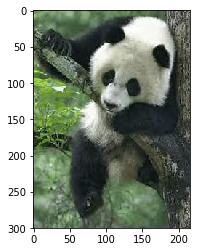

In [13]:
# Now, display a few images.   Let's see what image_0015.jpg looks like.
panda = cv2.imread("/data/ftian/xdrive/images/101_ObjectCategories/panda/image_0015.jpg")
panda = cv2.cvtColor(panda, cv2.COLOR_BGR2RGB)
plt.imshow(panda)
plt.show()

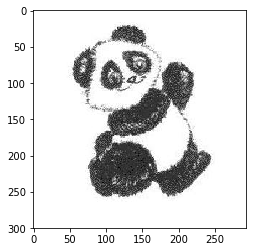

In [15]:
# Now, let's look at another one 0016.  This one is a carton panda and we will see
# that this kind of dirty data will cause googlenet some trouble.
panda = cv2.imread("/data/ftian/xdrive/images/101_ObjectCategories/panda/image_0016.jpg")
panda = cv2.cvtColor(panda, cv2.COLOR_BGR2RGB)
plt.imshow(panda)
plt.show()

In [16]:
# 
# Next we will run a image recognition task.
# Note that the following, is simply a SQL query that user can type in.
# To disect the query, please look at those -- XXX: comments, bottom up.
# It will explain how we constructed this query step by step.
#
gnet = dg.xtable.fromQuery(con, '''
--
-- XXX: 
-- further processing of the column names, make the human readable.
--
select substr(filename, 54) as filename, nth, score, substr(tag, 0, 40) as tag from (
--
-- XXX: 
-- This just retrieve the result of googlenet, give each column a 
-- better name.
-- 
select 
dg_utils.transducer_column_text(1) as filename,
dg_utils.transducer_column_int4(2) as nth, 
dg_utils.transducer_column_float4(3) as score,
dg_utils.transducer_column_text(4) as tag,
--
-- XXX: 
-- This step, run a gnet() function, which will run googlenet
-- which is a performed in FPGA.
--
gnet(), t.*  
--
-- XXX: subquery t.
-- the following from clause, simply says we will read images
-- 
from (
    select dir || '/' || basename from imagefiles where 
    (basename like '%jpeg' or basename like '%jpg')
    and dir like '%panda%'
) t
) tmpt
''')
print(gnet.show())


+------------+-------+-------------+-----------------------------------------+
| filename   |   nth |       score | tag                                     |
|------------+-------+-------------+-----------------------------------------|
| 4.jpg      |     0 | 0.245997    | n03720891 maraca                        |
| 4.jpg      |     1 | 0.168237    | n03929660 pick, plectrum, plectron      |
| 4.jpg      |     2 | 0.130034    | n04579432 whistle                       |
| 4.jpg      |     3 | 0.0891868   | n03840681 ocarina, sweet potato         |
| 4.jpg      |     4 | 0.0366025   | n03476684 hair slide                    |
| 9.jpg      |     0 | 0.168759    | n03944341 pinwheel                      |
| 9.jpg      |     1 | 0.103252    | n03476684 hair slide                    |
| 9.jpg      |     2 | 0.0507403   | n02085620 Chihuahua                     |
| 9.jpg      |     3 | 0.0330151   | n04399382 teddy, teddy bear             |
| 9.jpg      |     4 | 0.0312924   | n04548280 wall 

In [17]:
# 
# We still run the DNN on all images.  But we only show file 0015 and 0016.
# For each image, googlenet will try to classify it to a category (tag).  
# googlenet will "guess" top 5 most likely catogories, score is the likelyhood.
# The result says, 
# 0015.jpg, is 99.9% likely to be a giant panda
# 0016.jpg, is 33% likely to be a teddy bear,
#           is 31% to be an indri (a kind of monkey)
# etc etc.
# You can see, googlenet is not sure what 0016.jpg is --  
# see picutres above, 0016 is an carton panda, kind of like a bear/monkey, well.
#
qexp = gnet.select(select='filename, nth, score, tag', 
                 where = "filename like '%0015.jpg' or filename like '%0016.jpg'")
print (qexp.show())

+------------+-------+---------+-------+
| filename   | nth   | score   | tag   |
|------------+-------+---------+-------|
+------------+-------+---------+-------+


In [29]:
# 
# Let's run again, the following query basically says googlenet guessed wrong.
# It is very useful to debug the model.  We can see googlenet actually doing 
# quite well, even if it think the picuture is not a panda, most of the time
# googlenet say it is a teddy bear or similar animal.
# 
# but 0026.jpg is interesting -- googlenet is 99% sure it is a soccer ball!
# 
q1 = gnet.select(select='filename, nth, score, tag', where = "nth = 0 and tag not like 'n02510455%'")
print (q1.show())

+----------------+-------+-----------+-----------------------------------------+
| filename       |   nth |     score | tag                                     |
|----------------+-------+-----------+-----------------------------------------|
| image_0010.jpg |     0 | 0.855697  | n04399382 teddy, teddy bear             |
| image_0011.jpg |     0 | 0.342574  | n03724870 mask                          |
| image_0018.jpg |     0 | 0.124651  | n03476684 hair slide                    |
| image_0025.jpg |     0 | 0.968536  | n04399382 teddy, teddy bear             |
| image_0036.jpg |     0 | 0.0752547 | n03534580 hoopskirt, crinoline          |
| image_0038.jpg |     0 | 0.67436   | n04399382 teddy, teddy bear             |
| image_0021.jpg |     0 | 0.654912  | n04399382 teddy, teddy bear             |
| image_0023.jpg |     0 | 0.228846  | n03124043 cowboy boot                   |
| image_0029.jpg |     0 | 0.159259  | n02134418 sloth bear, Melursus ursinus, |
| image_0031.jpg |     0 | 0

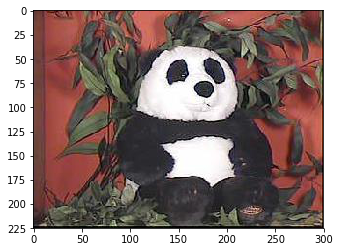

In [18]:
# 
# Let's see the soccerball.  :-)
# The face of the carton panda indeed looks like a soccer ball. 
#
panda = cv2.imread("/data/ftian/xdrive/images/101_ObjectCategories/panda/image_0026.jpg")
panda = cv2.cvtColor(panda, cv2.COLOR_BGR2RGB)
plt.imshow(panda)
plt.show()

In [19]:
# 
# Again, we can run googlenet, then doing group by.   Now we can see 
# for these panda pictures, we guessed 18 panda, and 9 teddy bear.
#
gnet = dg.xtable.fromQuery(con, '''
select tag, count(*) as cnt from (
select 
dg_utils.transducer_column_text(1) as filename,
dg_utils.transducer_column_int4(2) as nth, 
dg_utils.transducer_column_float4(3) as score,
dg_utils.transducer_column_text(4) as tag,
gnet(), t.*
from (
    select dir || '/' || basename from imagefiles where 
    (basename like '%jpeg' or basename like '%jpg')
    and dir like '%panda%'
) t
) tmpt 
where nth = 0
group by tag
''')


print(gnet.show())

+-----------------------------------------------------------------------------+-------+
| tag                                                                         |   cnt |
|-----------------------------------------------------------------------------+-------|
| n03724870 mask                                                              |     1 |
| n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca |    18 |
| n03720891 maraca                                                            |     1 |
| n02096585 Boston bull, Boston terrier                                       |     1 |
| n03534580 hoopskirt, crinoline                                              |     1 |
| n03124043 cowboy boot                                                       |     1 |
| n02134418 sloth bear, Melursus ursinus, Ursus ursinus                       |     1 |
| n03944341 pinwheel                                                          |     1 |
| n04399382 teddy, teddy bear   

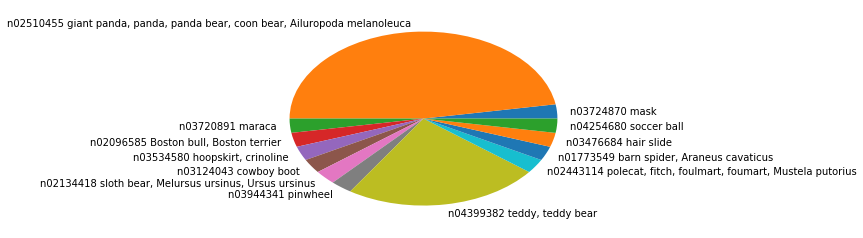

In [20]:
#
# Plot the above query as pie chart.  
# Just to show that deepgreen has some tools do some in browser plotting.
# 
import dg.dsutil.plot
rows = gnet.execute()
pc = dg.dsutil.plot.PieChart(gnet.coldata('cnt', rows), labels=gnet.coldata('tag', rows))
pc.draw()